In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader



In [2]:
my_classs = ('class1','class2','class3','class4','class5','class6','class7','class8','class9')

In [3]:
class  Training_DataSet(Dataset):
    def __init__(self,csv_file,root_dir,transform):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        features = self.data.iloc[idx]  
        target = features['target'] #yoyoy
        features = features.drop(labels='id',axis=0)
        features = features.drop(labels='target',axis=0)
        
        sample = {"features":features,"target":target}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [4]:
def isdigit(target):
    digit = 0
    for i in(target):
        if i.isdigit():
            digit = i
    return digit

In [5]:


class to_tensor_training(object):
    def __call__(self,sample):
        features , target = sample['features'],sample['target']
        features = np.array([features])
        features = features.astype('float32')
        features = torch.from_numpy(features)
        features = features.float()
        target = isdigit(target)
        target = int(target)-1

        target = np.array([target])
        target = torch.from_numpy(target)
        target = target.long()
        
        return {"features":features,"target":target}
        

In [6]:
transformed_dataset = Training_DataSet(csv_file="train.csv",
                                       root_dir="/Users/abdulsalamyazid/Desktop/Projects/Kaggle",
                                       transform = to_tensor_training())

In [7]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['features'].dtype,sample['target'])

    if i == 3:
        break

0 torch.float32 tensor([0])
1 torch.float32 tensor([0])
2 torch.float32 tensor([0])
3 torch.float32 tensor([0])


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(93,128)
        self.fc2 = nn.Linear(128,256)
        self.fc3 = nn.Linear(256,512)
        self.fc4 = nn.Linear(512,64)
        self.fc5 = nn.Linear(64,9)
        
    def forward(self,x):
        #drouput_activation1 = nn.Dropout(p=0.3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
        

In [9]:
net = Net()

In [10]:
trainloader = torch.utils.data.DataLoader(transformed_dataset,batch_size=4, shuffle=True,num_workers=2)


In [11]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
loss_array = []
correct = 0
total = 0

accuracy_array = []
for epoch in range(11):
    running_loss = 0
    for i , data in enumerate(trainloader,0):
        features , target = data['features'],data['target']
        target = target.squeeze()
        optimizer.zero_grad()
        outputs = net(features)
        outputs = outputs.squeeze()
        _, predictions = torch.max(outputs,1)
        total += target.size(0)
        print(predictions.shape)
        print(target.shape)
        correct += (predictions == target).sum().item()
        loss = criterion(outputs,target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        
    loss_array.append(running_loss / len(trainloader))
    
    print("Epoch: {}/ 10.. ".format(epoch+1),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)))
    print("Accuracy  %d %%" %(100*correct/total))
    correct = 0
    total = 0
print("Finished training")

torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Si

KeyboardInterrupt: 

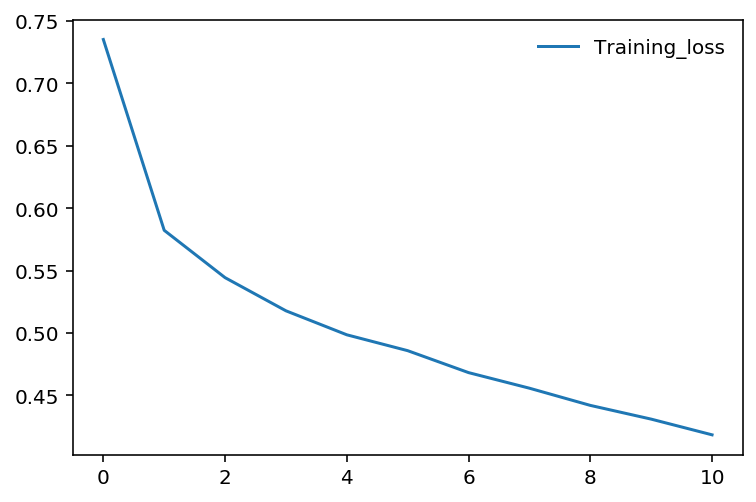

In [13]:
# Let us plot our loss over time
%matplotlib inline
%config InlineBackend.figure_format = "retina"


import matplotlib.pyplot as plt

plt.plot(loss_array,label="Training_loss")
plt.legend(frameon=False)

In [14]:
def view_classify( ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.axis('off')
    ax2.barh(np.arange(9), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['class1','class2','class3','class4','class5','class6','class7','class8','class9'])
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()


tensor([7])


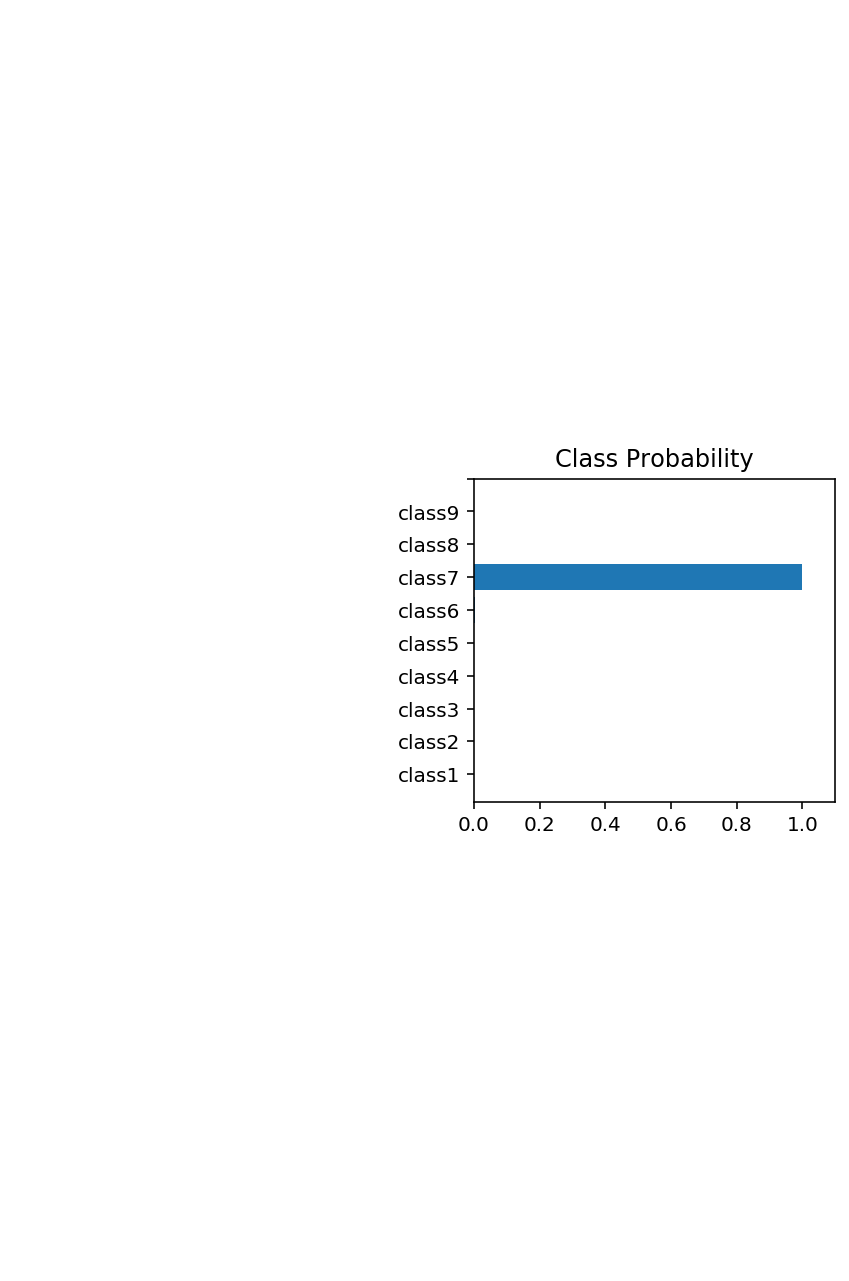

In [15]:
sample = next(iter(transformed_dataset))
sample = next(iter(transformed_dataset))
sample = transformed_dataset[46060]
feature ,target = sample['features'],sample['target']
output = net(feature)
feature = F.log_softmax(output, dim=1)
ps = torch.exp(feature)
print(target+1)
view_classify(ps)

In [17]:
#Lets save the model
print(net.state_dict().keys())

#Let us save the state dict
torch.save({
    'model_state_dict' : net.state_dict()
}, "OttoGroup.pth")



odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias'])
